In [72]:
# Import libraries
from math import atan2, cos, sin, sqrt, pi
import numpy as np
import cv2 as cv2
import os
import glob
import time
from scipy.signal import butter, lfilter
from scipy import signal
from scipy.signal import find_peaks, resample_poly
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing
from ipywidgets import interactive, widgets
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
from matplotlib.image import imread
import matplotlib.pyplot as plt 
from PIL import Image

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting plotting parameters
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18) 

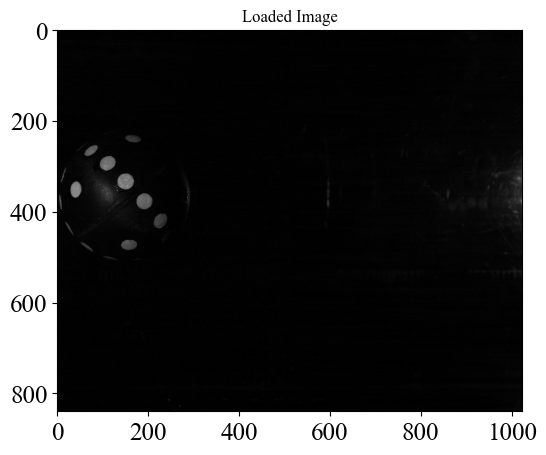

(840, 1024)

In [7]:
# Load the TIFF image
file_path = r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\2100K_FST_972_FF_run\Partition 1001274.tif"
image = Image.open(file_path)
image_array = np.array(image)

# Display the first frame for inspection
plt.figure(figsize=(6, 6))
plt.imshow(image_array, cmap='gray')
plt.title("Loaded Image")
plt.axis("on")
plt.show()

# Check image properties
image_array.shape

No circles detected.


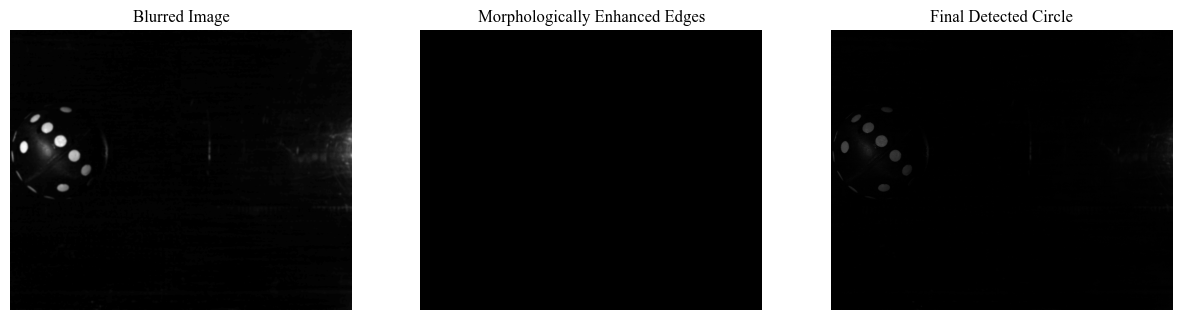

In [44]:

# Convert to 8-bit grayscale if necessary
if image_array.dtype == np.uint16:
    image_array = (image_array / 16).astype(np.uint8)  # Scale from 12-bit/16-bit to 8-bit

# Apply Gaussian blur to reduce noise and improve edge detection
blurred = cv2.GaussianBlur(image_array, (9, 9), 0)

# Apply Canny edge detection with adjusted thresholds
edges = cv2.Canny(blurred, 80, 200)

# Apply morphological closing to enhance circular edges
kernel = np.ones((5, 5), np.uint8)
closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

# Apply Hough Circle Transform with optimized parameters
detected_circles = cv2.HoughCircles(
    closed_edges,
    cv2.HOUGH_GRADIENT,
    dp=1.2,
    minDist=50,
    param1=80,  # Edge detection threshold
    param2=40,  # Accumulator threshold for circle detection
    minRadius=50,  # Ignore small false detections
    maxRadius=300,  # Ensure large circle detection
)

# Convert grayscale to RGB for visualization
output = cv2.cvtColor(image_array, cv2.COLOR_GRAY2BGR)

# Draw detected circles
if detected_circles is not None:
    detected_circles = np.uint16(np.around(detected_circles))
    for pt in detected_circles[0, :]:
        a, b, r = pt
        cv2.circle(output, (a, b), r, (0, 255, 0), 3)  # Draw circle
        cv2.circle(output, (a, b), 2, (0, 0, 255), 3)  # Draw center

    print(f"Detected Circle: Center ({a}, {b}), Radius {r}")

else:
    print("No circles detected.")

# Display results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(blurred, cmap='gray')
ax[0].set_title("Blurred Image")
ax[0].axis("off")

ax[1].imshow(closed_edges, cmap='gray')
ax[1].set_title("Morphologically Enhanced Edges")
ax[1].axis("off")

ax[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
ax[2].set_title("Final Detected Circle")
ax[2].axis("off")

plt.show()




Detected Circle: Center (146, 346), Radius 141


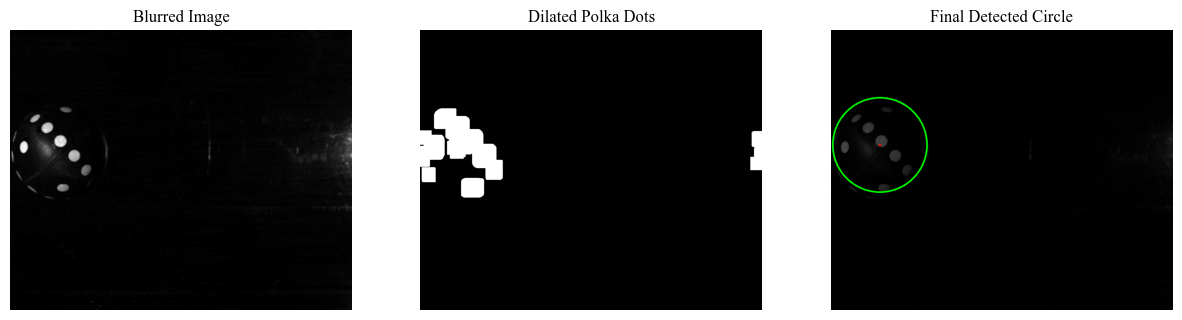

In [53]:
# 1. Convert to 8-bit grayscale if necessary
if image_array.dtype == np.uint16:
    # Scale from 16-bit (or 12-bit stored as 16-bit) down to 8-bit
    image_array = (image_array / 16).astype(np.uint8)

# 2. (Optional) Slight Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(image_array, (5, 5), 0)

# 3. Threshold the bright polka dots
#    Adjust 'dot_threshold' based on your image brightness
dot_threshold = 30
_, dots_thresh = cv2.threshold(blurred, dot_threshold, 255, cv2.THRESH_BINARY)

# 4. Morphological dilation to merge individual polka dots into one large region
#    Increase or decrease kernel size depending on dot spacing
kernel = np.ones((40, 40), np.uint8)
merged_dots = cv2.dilate(dots_thresh, kernel, iterations=1)

# 5. Find contours in the merged dots image
contours, _ = cv2.findContours(merged_dots, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Prepare an output image for drawing
output = cv2.cvtColor(image_array, cv2.COLOR_GRAY2BGR)

if contours:
    # 6. Pick the largest contour (assuming it corresponds to the merged sphere region)
    largest_contour = max(contours, key=cv2.contourArea)

    # 7. Fit a circle around that contour
    (cx, cy), radius = cv2.minEnclosingCircle(largest_contour)
    cx, cy, radius = int(cx), int(cy), int(radius)

    # 8. Draw the detected circle on the output image
    cv2.circle(output, (cx, cy), radius, (0, 255, 0), 3)
    cv2.circle(output, (cx, cy), 2, (0, 0, 255), 3)

    print(f"Detected Circle: Center ({cx}, {cy}), Radius {radius}")
else:
    print("No polka-dot contours found. Try adjusting threshold or kernel size.")

# 9. Display the results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(blurred, cmap='gray')
ax[0].set_title("Blurred Image")
ax[0].axis("off")

ax[1].imshow(merged_dots, cmap='gray')
ax[1].set_title("Dilated Polka Dots")
ax[1].axis("off")

ax[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
ax[2].set_title("Final Detected Circle")
ax[2].axis("off")

plt.show()


(-0.5, 1023.5, 839.5, -0.5)

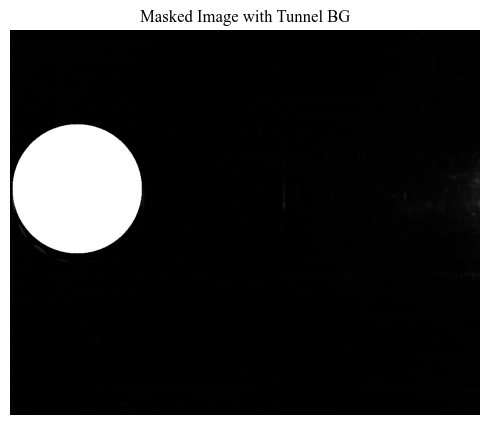

In [70]:
mask = np.zeros_like(image_array, dtype=np.uint8)
mask_inv = cv2.bitwise_not(mask)
result = cv2.bitwise_and(image_array, image_array, mask=mask_inv)
cv2.circle(result, (cx, cy), radius, 255, -1)
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Masked Image with Tunnel BG")
plt.axis("off")

In [88]:
im_dir1 = r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\2100K_FST_972_FF_run"
im_dir2 = r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\480K_FST_972_FF_Run_C001H001S0001"
files1  = sorted(glob.glob(os.path.join(im_dir1, "*.tif"))) 
files2  = sorted(glob.glob(os.path.join(im_dir2, "*.tif"))) 
#glob.glob lists all files that start with im_dir and end with tif
output_dir1= r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Masked_images"
os.mkdir(output_dir1)
output_dir2=r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\Masked_images"
os.mkdir(output_dir2)


In [ ]:
##Create Masked Images and save them in a seperate folder 
start_img=1200
end_img=1920
for i in range (start_img,end_img):
    im_path=files1[i] #if you use enumerate, i has index and name of the file, you only need the name
    image = Image.open(im_path)
    image_array = np.array(image)
    # 1. Convert to 8-bit grayscale if necessary
    if image_array.dtype == np.uint16:     # Scale from 16-bit (or 12-bit stored as 16-bit) down to 8-bit
        image_array = (image_array / 16).astype(np.uint8)

    # 2. (Optional) Slight Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image_array, (5, 5), 0)

    # 3. Threshold the bright polka dots
    #    Adjust 'dot_threshold' based on your image brightness
    dot_threshold = 30
    _, dots_thresh = cv2.threshold(blurred, dot_threshold, 255, cv2.THRESH_BINARY)

    # 4. Morphological dilation to merge individual polka dots into one large region
    #    Increase or decrease kernel size depending on dot spacing
    kernel = np.ones((40, 40), np.uint8)
    merged_dots = cv2.dilate(dots_thresh, kernel, iterations=1)

    # 5. Find contours in the merged dots image
    contours, _ = cv2.findContours(merged_dots, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Prepare an output image for drawing
    output = cv2.cvtColor(image_array, cv2.COLOR_GRAY2BGR)

    if contours:
        # 6. Pick the largest contour (assuming it corresponds to the merged sphere region)
        largest_contour = max(contours, key=cv2.contourArea)

        # 7. Fit a circle around that contour
        (cx, cy), radius = cv2.minEnclosingCircle(largest_contour)
        cx, cy, radius = int(cx), int(cy), int(radius)

        # 8. Draw the detected circle on the output image
        cv2.circle(output, (cx, cy), radius, (0, 255, 0), 3)
        cv2.circle(output, (cx, cy), 2, (0, 0, 255), 3)
        print(f"Detected Circle: Center ({cx}, {cy}), Radius {radius}")
    else:
        print("No polka-dot contours found. Try adjusting threshold or kernel size.")
    
    mask = np.zeros_like(image_array, dtype=np.uint8)
    mask_inv = cv2.bitwise_not(mask)
    result = cv2.bitwise_and(image_array, image_array, mask=mask_inv)
    cv2.circle(result, (cx, cy), radius, 255, -1)

    # Save the resulting image
    output_path = os.path.join(output_dir1, os.path.basename(im_path))
    cv2.imwrite(output_path, result)
    print(f"Processed {im_path} and saved masked image to {output_path}")


Detected Circle: Center (72, 332), Radius 133
Processed D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\2100K_FST_972_FF_run\Partition 1001201.tif and saved masked image to D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Masked_images\Partition 1001201.tif
Detected Circle: Center (71, 333), Radius 133
Processed D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\2100K_FST_972_FF_run\Partition 1001202.tif and saved masked image to D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Masked_images\Partition 1001202.tif
Detected Circle: Center (73, 332), Radius 133
Processed D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\2100K_FST_972_FF_run\Partition 1001203.tif and saved masked image to D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Masked_images\Partition 1001203.tif
Detected Circle: Center (73, 332), Radius 134
Processed D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\2100K_FST_972_FF_run\Partition 1001204.tif and saved masked image to D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Masked_images\Partition 

In [192]:
# -----------------------------
# User-Defined Paths (update these for the 2 cameras accordingly)
# # Stationary reference background image
stationary_image_path = r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\2100K_FST_972_FF_run\Partition 1000001.tif" 
#"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\480K_FST_972_FF_Run_C001H001S0001\480K_FST_972_FF_Run_C001H001S0001000001.tif"   
masked_folder         = output_dir1         # Folder with masked images (sphere replaced with white)
original_folder       = im_dir1             # Folder with original images (to be aligned)
aligned_img_dir2      = r"D:\FST_972_FF_Sphere\FST_972_Run\480K_FF_Run\Aligned_images"
aligned_img_dir1      = r"D:\FST_972_FF_Sphere\FST_972_Run\2100K_FF_Run\Aligned_images"
output_folder         = aligned_img_dir1    # Folder to save the aligned images

In [193]:
# -----------------------------
# Create output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# -----------------------------
# Load the stationary (reference) image in grayscale
s = Image.open(stationary_image_path)
stationary = np.array(s)
    # 1. Convert to 8-bit grayscale if necessary
if stationary.dtype == np.uint16:     # Scale from 16-bit (or 12-bit stored as 16-bit) down to 8-bit
    stationary = (stationary / 16).astype(np.uint8)
# -----------------------------
# Get sorted lists of masked and original images
masked_files   = sorted(glob.glob(os.path.join(masked_folder, "*.tif*")))
original_files = sorted(glob.glob(os.path.join(original_folder, "*.tif*")))[1200:1920]

if len(masked_files) == 0 or len(original_files) == 0:
    raise IOError("No masked or original images found in the specified folders.")


In [194]:
# List to store computed shifts (each element will be [dy, dx])
shifts_array = []

# Define your cropped region coordinates for ECC (using y and x indices)
y_start = 800      # Start cropping from row 800 to the end
x_start = 0        # Start cropping from column 0
x_end = 500        # Crop up to column 500

# Define ECC parameters
warp_mode = cv2.MOTION_TRANSLATION  # For translation only
# Initial warp matrix for translation is a 2x3 identity matrix
initial_warp = np.eye(2, 3, dtype=np.float32)
# Termination criteria: either 50 iterations or epsilon of 1e-4
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 1e-4)

for i in range(len(masked_files)):
    masked_path = masked_files[i]    # Masked image (with sphere masked out)
    original_path = original_files[i]
    
    # Load images using PIL and convert to NumPy arrays
    masked_image = Image.open(masked_path)
    masked_img = np.array(masked_image)
    if masked_img.dtype == np.uint16:
        masked_img = (masked_img / 16).astype(np.uint8)
    
    original_image = Image.open(original_path)
    original_img = np.array(original_image)
    if original_img.dtype == np.uint16:
        original_img = (original_img / 16).astype(np.uint8)
    
    # -----------------------------
    # Create a background mask:
    # Assumption: The sphere is masked (set to white, 255) so background pixels are not 255.
    background_mask = (masked_img != 255).astype(np.uint8)
    
    # Zero out the sphere region in both the stationary and masked images.
    # 'stationary' is assumed to be already loaded (the stationary reference image).
    stationary_bg = stationary.copy()
    masked_bg = masked_img.copy()
    stationary_bg[background_mask == 0] = 0
    masked_bg[background_mask == 0] = 0

    # -----------------------------
    # Crop the region for ECC.
    # (Here, we're using the region [y_start:, x_start:x_end])
    stationary_crop = stationary_bg[y_start:, x_start:x_end]
    masked_crop = masked_bg[y_start:, x_start:x_end]
    
    # Convert cropped regions to float32 (required for ECC)
    stationary_crop_float = stationary_crop.astype(np.float32)
    masked_crop_float = masked_crop.astype(np.float32)
    
    # -----------------------------
    # Perform ECC alignment on the cropped region.
    warp_matrix = initial_warp.copy()
    try:
        # findTransformECC returns the enhanced correlation coefficient and updates warp_matrix.
        cc, warp_matrix = cv2.findTransformECC(stationary_crop_float, masked_crop_float,
                                               warp_matrix, warp_mode, criteria)
    except cv2.error as e:
        print(f"ECC alignment failed for {os.path.basename(original_path)}: {e}")
        warp_matrix = np.eye(2, 3, dtype=np.float32)  # fallback: no shift
    
    # For translation, warp_matrix is of the form: [[1, 0, dx], [0, 1, dy]]
    dx = warp_matrix[0, 2]
    dy = warp_matrix[1, 2]
    print(f"{os.path.basename(original_path)}: ECC shift (dy, dx) = ({dy:.2f}, {dx:.2f})")
    shifts_array.append([dy, dx])
    
    # -----------------------------
    # Apply the computed warp (translation) to the full original image.
    h, w = original_img.shape[:2]
    aligned_img = cv2.warpAffine(original_img, warp_matrix, (w, h))
    
    # Save the aligned image.
    output_path = os.path.join(output_folder, os.path.basename(original_path))
    cv2.imwrite(output_path, aligned_img)

# Convert the shifts list to a NumPy array for further use or analysis.
shifts_array = np.array(shifts_array)
print("Final shifts array (each row is [dy, dx]):")
print(shifts_array)


Partition 1001201.tif: ECC shift (dy, dx) = (-0.08, 0.45)
Partition 1001202.tif: ECC shift (dy, dx) = (0.03, 0.51)
Partition 1001203.tif: ECC shift (dy, dx) = (-0.13, 0.48)
Partition 1001204.tif: ECC shift (dy, dx) = (0.02, 0.53)
Partition 1001205.tif: ECC shift (dy, dx) = (0.03, 0.48)
Partition 1001206.tif: ECC shift (dy, dx) = (-0.13, 0.57)
Partition 1001207.tif: ECC shift (dy, dx) = (-0.11, 0.51)
Partition 1001208.tif: ECC shift (dy, dx) = (-0.05, 0.51)
Partition 1001209.tif: ECC shift (dy, dx) = (-0.02, 0.53)
Partition 1001210.tif: ECC shift (dy, dx) = (-0.05, 0.43)
Partition 1001211.tif: ECC shift (dy, dx) = (-0.12, 0.46)
Partition 1001212.tif: ECC shift (dy, dx) = (-0.14, 0.52)
Partition 1001213.tif: ECC shift (dy, dx) = (0.11, 0.57)
Partition 1001214.tif: ECC shift (dy, dx) = (0.02, 0.50)
Partition 1001215.tif: ECC shift (dy, dx) = (-0.00, 0.65)
Partition 1001216.tif: ECC shift (dy, dx) = (-0.01, 0.63)
Partition 1001217.tif: ECC shift (dy, dx) = (-0.07, 0.52)
Partition 1001218.t

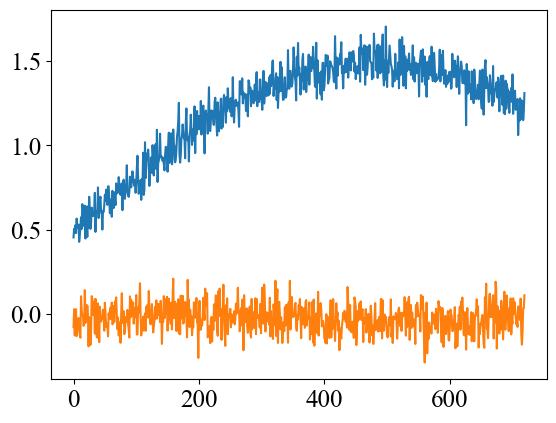

In [195]:
shift_df = pd.DataFrame(shifts_array)
shift_df.head()
x = shift_df[1]
y = shift_df[0]
plt.figure()
plt.plot(np.arange(0,720),x)
plt.plot(np.arange(0,720),y)
#plt.plot(x,y)